<a href="https://colab.research.google.com/github/YoelRoger/UM-ModelosySimulacion/blob/main/ModeloPoblacionalEjercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalación de las librerías

In [2]:
!pip install pint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 7.1 MB/s eta 0:00:00


In [3]:
pip install modsimpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for modsimpy: filename=modsimpy-1.1.3-py3-none-any.whl size=20354 sha256=5d0fc40bc9f5632e4d256fab4111ca17021e1480a25166374b3a9b6ef002dbfc
  Stored in directory: /root/.cache/pip/wheels/3a/21/22/b652cf3a4fc674c3377fdeb77da04bba02954a4ea5abe331be
Successfully built modsimpy


**IMPORTS**

In [4]:
from pandas import read_html
import pandas as pd
import modsim as ms
from matplotlib import pyplot

#Modelo poblacional
Vamos a simular con un modelo la obtención de datos históricos de población ya conocidos. Es decir, vamos a ajustar un modelo a estos datos, para obtener las ecuaciones que modelan al sistema.
Al obtener el modelo poblacional podemos llegar a estimar la población en los sgtes. años.
Los datos poblacionales los obtendremos de un artículo de wikipedia acerca de la población mundial.


Importamos las liberías y obtenemos las tablas del artículo

In [27]:
url = "https://en.wikipedia.org/wiki/Estimates_of_historical_world_population"

tablas = pd.read_html(url, header=0, index_col=0, decimal='M')

tabla_poblacion = tablas[2] #guardamos en una variable la tercer tabla del artículo

In [28]:
tabla_poblacion.columns = [ 'census' , 'prb' , 'un' , 'maddison' ,'hyde' , 'tanton' , 'biraben' , 'mj' ,'thomlinson' , 'durand' , 'clark' ]

In [29]:
censo = tabla_poblacion.census/1e9
un = tabla_poblacion.un/1e9

#Proyecciones de expertos

Desde el artículo de wikipedia analizamos las gráficas de estimaciones.

In [39]:
# proyecciones de los expertos
import pandas as pd
def read_table3(filename = 'https://en.wikipedia.org/w/index.php?title=Estimates_of_historical_world_population&oldid=938127092'):
    tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
    table3 = tables[3]
    table3.columns = ['censo', 'prb', 'un']
    return table3

tabla3 = read_table3()

def plot_projecciones(table):
    censo_proj = table.censo / 1e9
    un_proj = table.un / 1e9

    ms.plot(censo_proj.dropna(), 'b:', label='Proyección US') 
    ms.plot(un_proj.dropna(), 'g--', label='Proyección UN')
    ms.decorate(xlabel="Años", ylabel="Población")

#Proyecciones US, UN, Alpha y Cuadratico

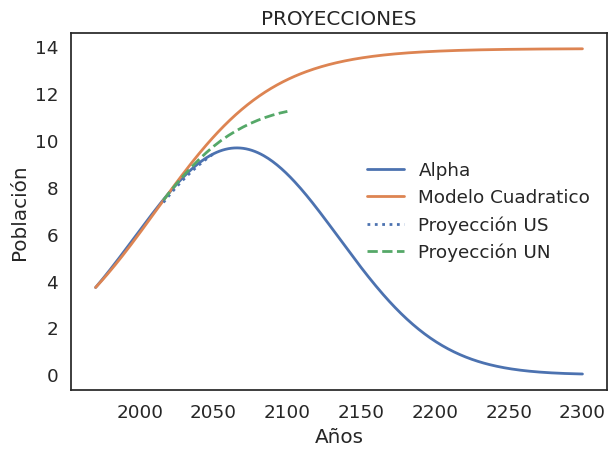

In [40]:
# Definimos la recta

def recta_alpha(t):
    b = 0.02
    m = -0.00021
    return b + m * (t - 1970)

ts = ms.linrange(1960, 2300)
#print(ts)

alpha_model = ms.TimeSeries(recta_alpha(ts), ts) #guardamos los valores que calcula la recta año a año

t_0 = 1970
t_end = 2300
p_0 = censo[t_0]

sistema = ms.System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025, beta=-0.0018,
                funcion_alpha=recta_alpha) #en system agregamos la recta 

def step_alphadiff(pop, t, sistema):
    crecimiento_neto = sistema.funcion_alpha(t) * pop[t]
    return pop[t] + crecimiento_neto
    

def run_simulation(sistema, step_func):
    resultado = ms.TimeSeries()
    resultado[sistema.t_0] = sistema.p_0
    for t in ms.linrange(sistema.t_0, sistema.t_end):
        resultado[t+1] = step_func(resultado, t, sistema)
    return resultado


#CUADRATICO
def step_cuadratico(pop, t, sistema):
    crecimiento_neto = sistema.alpha * pop[t] + sistema.beta * pop[t]**2
    return pop[t] + crecimiento_neto

resultado_cuad = run_simulation(sistema, step_cuadratico)
resultado_alpha = run_simulation(sistema, step_alphadiff)
ms.plot(resultado_alpha, label="Alpha")
ms.plot(resultado_cuad, label="Modelo Cuadratico")
ms.decorate(title="PROYECCIONES")
ms.decorate(xlabel='Año')
plot_projecciones(tabla3)

#Ejercicio: 
graficar en un mismo gráfico las tres curvas de proyecciones, el modelo cuadrático, el modelo alpha y los datos de los expertos. Además, deben visualizarse los datos hitóricos. Responder teniendo en cuenta las poroyecciones de los expertos: 

1.    ¿Cuál será el mejor modelo* para estimar poblaciones en el año 2050? 
2.    ¿Cuál será el mejor modelo* para estimar poblaciones en el año 2100?

**Para las poblaciones superiores al año 2100 sera mejor usar el modelo cuadratico ya que se asemeja mas a la curva de los datos de los expertos. Caso contrario con los datos de los años anteriores al 2050, que se asemeja mejor el modelo Alpha, a mediano y corto plazo**

